In [14]:
# https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pickle
import os

import plotly.express as px

import geopandas as gpd ## geopandas gdal 
import fiona

In [56]:
# Opening path, streelamps & CCTV
fname = '../data/SingaporeStreetLampsCCTV.zip'
SLC = gpd.read_file(fname)
SLC

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,Lamps50m,Lamps25m,Lamps10m,CCTV100mRE,CCTV50mRE,CCTV25mRE,geometry
0,1,5115,tertiary,Keng Lee Road,None,F,50,0,F,F,13,6,4,0,0,0,"LINESTRING (103.84379 1.31370, 103.84468 1.31383)"
1,2,5115,tertiary,Keng Lee Road,None,F,50,0,F,F,10,4,2,0,0,0,"LINESTRING (103.84468 1.31383, 103.84495 1.313..."
2,3,5153,footway,None,None,B,0,0,F,F,5,1,0,0,0,0,"LINESTRING (103.84083 1.31463, 103.84115 1.31379)"
3,4,5153,footway,None,None,B,0,0,F,F,7,2,0,0,0,0,"LINESTRING (103.84115 1.31379, 103.84126 1.313..."
4,5,5122,residential,Sarkies Road,None,B,50,0,F,F,6,4,1,0,0,0,"LINESTRING (103.83721 1.31461, 103.83727 1.314..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50343,50344,5153,footway,None,None,B,0,0,F,F,4,2,1,0,0,0,"LINESTRING (103.84753 1.29756, 103.84767 1.297..."
50344,50345,5153,footway,None,None,B,0,0,F,F,1,0,0,0,0,0,"LINESTRING (103.84720 1.29759, 103.84721 1.297..."
50345,50346,5153,footway,None,None,B,0,0,F,F,1,0,0,0,0,0,"LINESTRING (103.84721 1.29759, 103.84721 1.297..."
50346,50347,5153,footway,None,None,B,0,0,F,F,0,0,0,0,0,0,"LINESTRING (103.84721 1.29753, 103.84720 1.29750)"


In [54]:
# Opening trees

fname = '../data/trees/trees.shp'

tdf = gpd.read_file(fname)
tdf

,height_est,geometry
0,12,POINT (103.81867 1.26622)
1,9,POINT (103.82051 1.26546)
2,12,POINT (103.82042 1.26549)
3,6,POINT (103.82056 1.26542)
4,12,POINT (103.82007 1.26551)
...,...,...
578765,6,POINT (103.68256 1.39834)
578766,3,POINT (104.02965 1.35194)
578767,3,POINT (104.03007 1.35219)
578768,0,POINT (104.03015 1.35314)


In [40]:
# Opening park facilities

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf = gpd.read_file('../data/park-facilities/park-facilities-kml.kml', driver='KML')
gdf['lon'] = gdf['geometry'].x
gdf['lat'] = gdf['geometry'].y
#Saving to shapefile
gdf.to_file("../data/park-facilities/park-facilities-kml.shp")
gdf.to_file("../data/park-facilities/park-facilities-kml.geojson")

<ipython-input-40-a9df760d3d72>:9: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.

<ipython-input-40-a9df760d3d72>:10: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



In [36]:
gdf

,Name,Description,geometry,lon,lat
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77146 1.44884 0.00000),103.771464,1.448836
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77885 1.45243 0.00000),103.778850,1.452432
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77764 1.45401 0.00000),103.777642,1.454011
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77878 1.45232 0.00000),103.778780,1.452315
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77380 1.45037 0.00000),103.773795,1.450367
...,...,...,...,...,...
2164,kml_2165,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81537 1.31131 0.00000),103.815371,1.311306
2165,kml_2166,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81643 1.32083 0.00000),103.816425,1.320825
2166,kml_2167,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81659 1.31717 0.00000),103.816587,1.317171
2167,kml_2168,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81516 1.32048 0.00000),103.815159,1.320484


In [38]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    

    #fig = px.scatter_geo(gdf, locations="geometry" )

    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
        # adding the lines joining the nodes
        
    fig.add_trace(go.Scattermapbox(
        name = "Parcs",
        mode = "markers",
        lon = gdf.lon,
        lat = gdf.lat,
        marker = {'size': 12, 'color':"blue"}))
    
    
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="open-street-map",#stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 15})
    fig.show()

In [3]:
def getNetworkAround(lat,lon,distm):
    fn = '../data/osmnx/'+str(lat)+"_"+str(lon)+"_"+str(distm)+'.pickle'
    if not os.path.isfile(fn):
        G = ox.graph_from_point((lat, lon), dist=distm, network_type='walk')
        with open(fn, 'wb') as f:
            pickle.dump(G, f)
    else:
        with open(fn,"rb") as f:
            G = pickle.load(f)
    return G

In [4]:
# Defining the map boundaries 
def showSGP():
    north, east, south, west = 1.327587854836542, 103.88297275579747, 1.2669696458157633, 103.79947552605792
    # Downloading the map as a graph object 
    G = ox.graph_from_bbox(north, south, east, west, network_type = 'walk',clean_periphery=False)  
    # Plotting the map graph 
    ox.plot_graph(G)

# Plotting the shortest path

In [5]:
def mapPath(G,origin_point,destination_point,WGT = 'length'):
    # define origin and desination locations 
    #origin_point = (1.278353050783832, 103.84105995326672) 
    #destination_point = (1.2853283229119088, 103.85262989657622)
    # get the nearest nodes to the locations 
    origin_node = ox.distance.nearest_nodes(G, origin_point[1],origin_point[0]) 
    destination_node = ox.distance.nearest_nodes(G, destination_point[1],destination_point[0])
    # printing the closest node id to origin and destination points origin_node, destination_node
    
        # Finding the optimal path 
    route = nx.shortest_path(G, origin_node, destination_node, weight = WGT) 
    # getting coordinates of the nodes
    # we will store the longitudes and latitudes in following list 
    long = [] 
    lat = []  
    for i in route:
        point = G.nodes[i]
        long.append(point['x'])
        lat.append(point['y'])
    plot_path(lat, long, origin_point, destination_point)
    route_map = ox.plot_route_folium(G, route)
    route_map.save('../data/osmnx/test.html')

# Custom edges values 

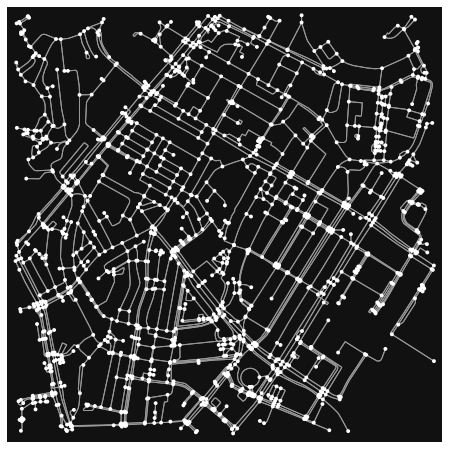

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [37]:
G = getNetworkAround(1.2806, 103.8464, 750)
ox.plot_graph(G)

In [48]:
for u,v,d in G.edges(data=True):
    d['weight'] = 10 +  1.0 / d['length']

In [49]:
origin_point = (1.2822526633223938, 103.84732075349544) 
destination_point = (1.2785088771898996, 103.8413733342337)

mapPath(G,origin_point,destination_point,WGT = 'weight')

In [47]:
origin_point = (1.2822526633223938, 103.84732075349544) 
destination_point = (1.2785088771898996, 103.8413733342337)

mapPath(G,origin_point,destination_point,WGT = 'length')